In [177]:
import numpy as np
import pandas as pd
import statsmodels
import tensorflow as tf
from datetime import date
from matplotlib import pyplot as plt
from scipy.stats import kstest
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [178]:
def prepare_data(data, sequence):
    data = data.set_index("Date")
    data["Year"] = data.index.year
    data["Month"] = data.index.month
    data["Weekday"] = data.index.weekday
    data = data.reindex(columns=sequence)
    return data

In [179]:
def plot_time_series(data_info, x_label, y_label, title):
    plt.figure(figsize=(12.80, 7.20), dpi=200)
    for data, color, label in data_info:
        plt.plot(data, color=color, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [180]:
def plot_time_series_lag(data, lag, title):
    plt.figure(figsize=(12.80, 7.20), dpi=200)
    pd.plotting.lag_plot(data, lag=lag)
    plt.title(title)
    plt.show()

In [181]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back, 0]
        data_x.append(data_window)
        data_y.append(data[i + look_back, 0])
    return np.array(data_x), np.array(data_y)

In [182]:
ether_data = pd.read_csv("Datasets/ETHUSD_Bitfinex_D_historical.csv")
ether_data.drop(labels=["Pair", "Volume_USD"], axis=1, inplace=True)
ether_data.rename(columns={"Volume_CCY":"Volume"}, inplace=True)
ether_data["Date"] = ether_data["TimeStamp"].apply(lambda timestamp: date.fromtimestamp(timestamp)).astype("datetime64")
ether_data.drop(labels="TimeStamp", axis=1, inplace=True)
column_sequence = ["Year", "Month", "Weekday", "Open", "High", "Low", "Close", "Volume"]
ether_data = prepare_data(ether_data, column_sequence)
ether_data = ether_data.sort_values("Date")

In [183]:
ether_data

,Year,Month,Weekday,Open,High,Low,Close,Volume
Date,,,,,,,,
2016-03-09,2016,3,2,10.300000,11.200000,10.10,11.200000,41.170000
2016-03-10,2016,3,3,11.200000,11.850000,11.07,11.750000,1.030000
2016-03-11,2016,3,4,11.750000,11.950000,11.75,11.950000,50.850000
2016-03-12,2016,3,5,11.950000,13.450000,11.95,12.920000,237.780000
2016-03-13,2016,3,6,12.920000,15.070000,12.92,15.070000,369.640000
...,...,...,...,...,...,...,...,...
2021-02-15,2021,2,0,1801.300000,1837.125887,1649.00,1779.425051,166031.099289
2021-02-16,2021,2,1,1778.500000,1828.300000,1725.00,1784.600000,106270.793237
2021-02-17,2021,2,2,1783.710981,1856.900000,1735.30,1848.700000,81646.318659


In [184]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1809 entries, 2016-03-09 to 2021-02-19
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     1809 non-null   int64  
 1   Month    1809 non-null   int64  
 2   Weekday  1809 non-null   int64  
 3   Open     1809 non-null   float64
 4   High     1809 non-null   float64
 5   Low      1809 non-null   float64
 6   Close    1809 non-null   float64
 7   Volume   1809 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 127.2 KB


In [185]:
ether_data.describe()

,Year,Month,Weekday,Open,High,Low,Close,Volume
count,1809.000000,1809.000000,1809.00000,1809.000000,1809.000000,1809.000000,1809.000000,1.809000e+03
mean,2018.158098,6.561636,3.00000,280.178019,291.973917,267.115741,281.243441,1.567702e+05
std,1.447989,3.442751,1.99917,296.450262,311.292744,280.463620,298.940045,1.693212e+05
min,2016.000000,1.000000,0.00000,6.682000,7.324000,5.861000,6.702000,0.000000e+00
25%,2017.000000,4.000000,1.00000,105.810000,109.170000,101.400000,106.050000,4.859756e+04
50%,2018.000000,7.000000,3.00000,206.560000,213.840000,197.860000,206.570000,1.096355e+05
75%,2019.000000,10.000000,5.00000,355.500000,371.000000,345.610000,355.620000,1.958973e+05
max,2021.000000,12.000000,6.00000,1938.300000,1948.845968,1934.800000,1941.600000,1.620940e+06


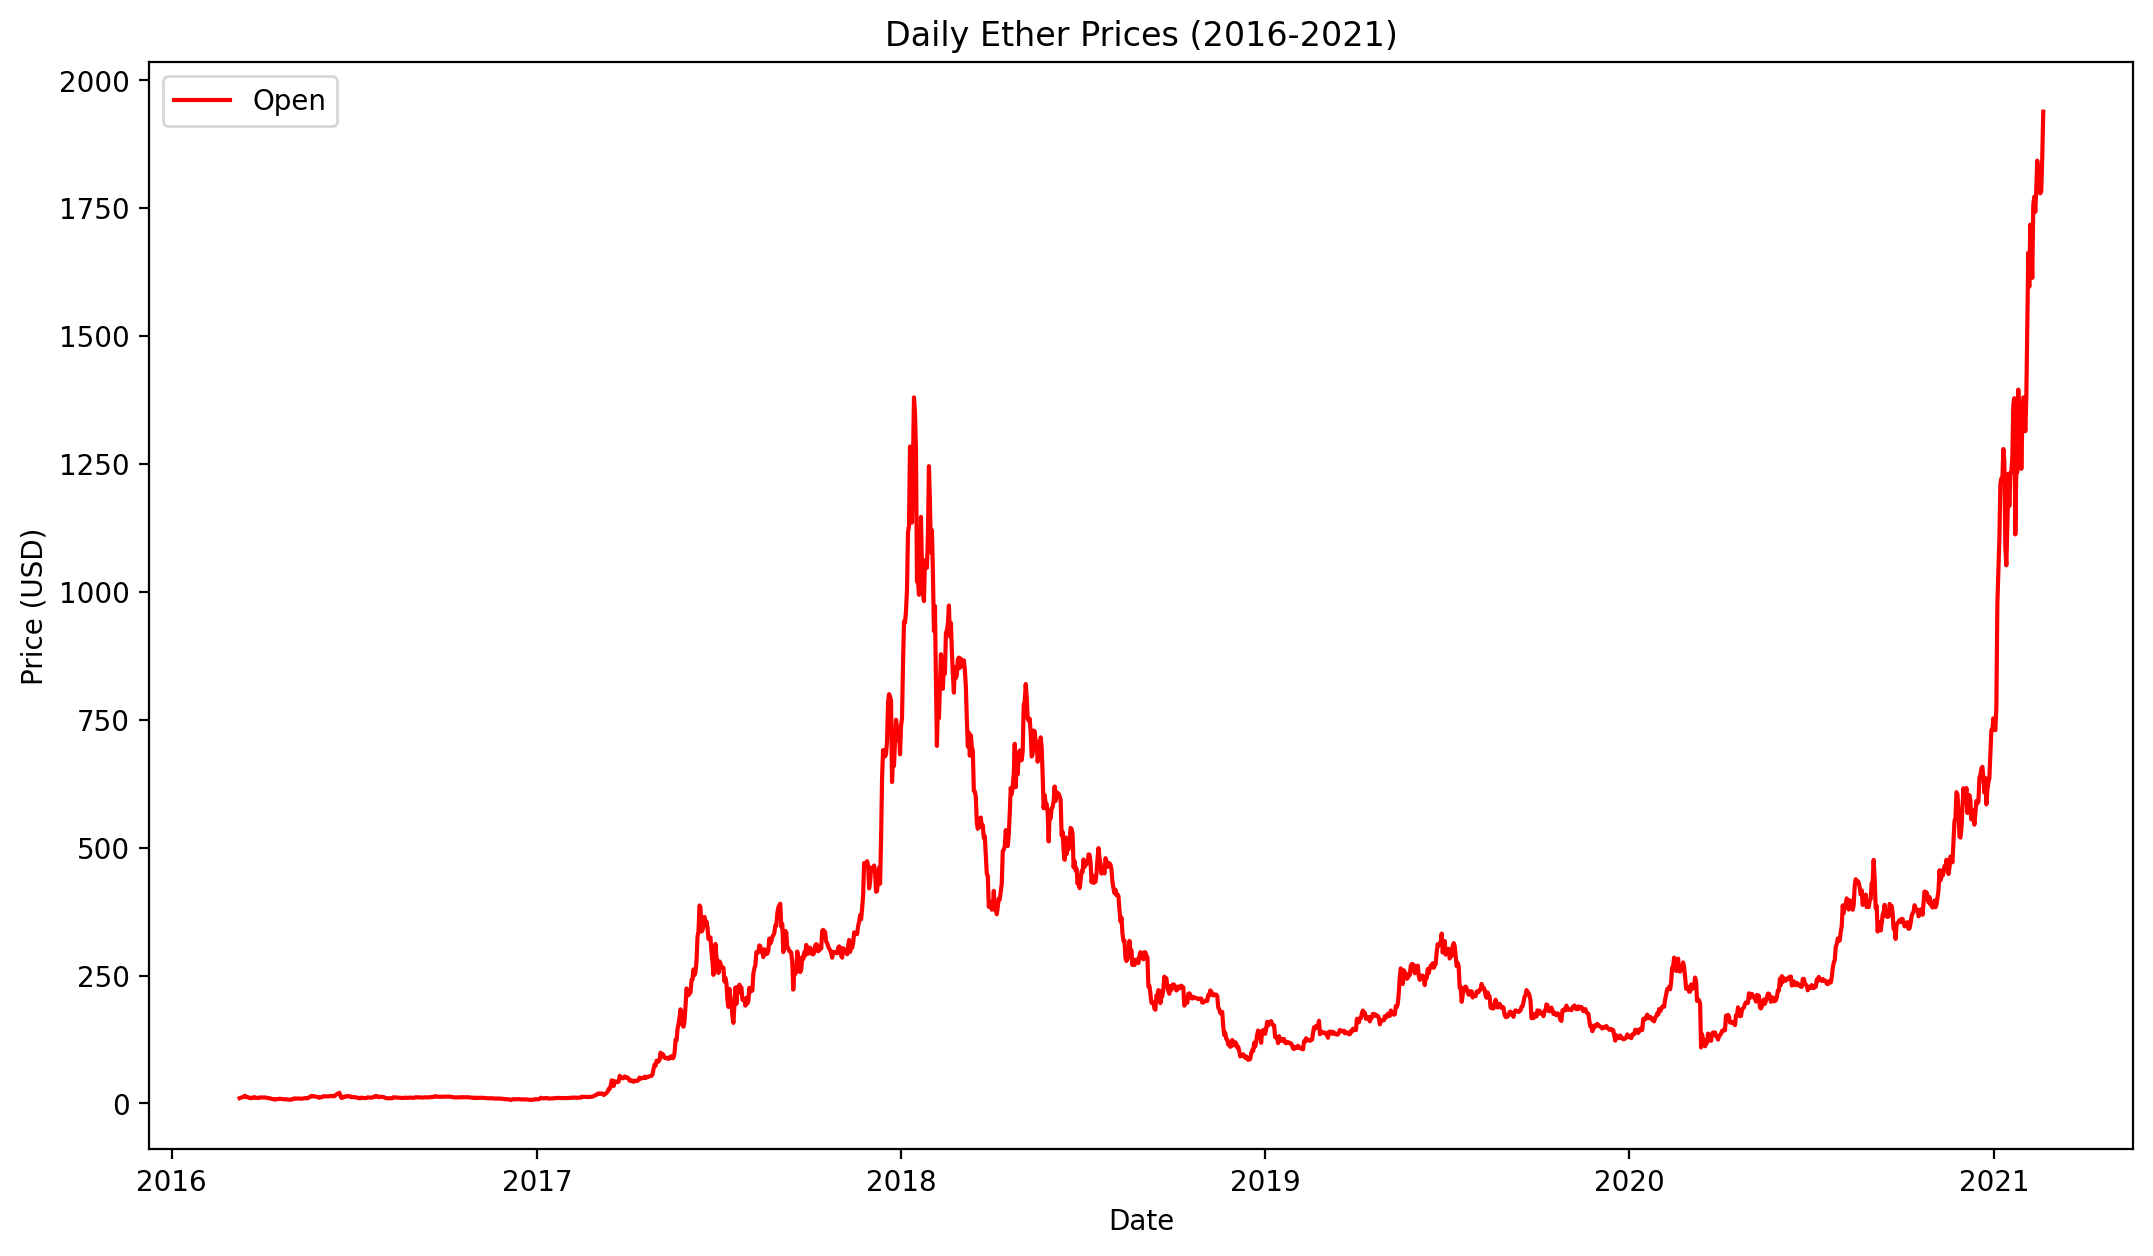

In [186]:
plot_time_series(((ether_data["Open"], "red", "Open"),), "Date", "Price (USD)", "Daily Ether Prices (2016-2021)")

In [187]:
rolling_mean = ether_data.rolling(window=7).mean()
rolling_standard_deviation = ether_data.rolling(window=7).std()
rolling_mean.dropna(axis=0, inplace=True)
rolling_mean.drop(labels=["Year", "Month", "Weekday"], axis=1, inplace=True)
rolling_standard_deviation.dropna(axis=0, inplace=True)
rolling_standard_deviation.drop(labels=["Year", "Month", "Weekday"], axis=1, inplace=True)

In [188]:
rolling_mean

,Open,High,Low,Close,Volume
Date,,,,,
2016-03-15,12.260000,13.144286,11.595714,12.635714,5484.104286
2016-03-16,12.654286,13.528571,11.955714,12.875714,6263.481429
2016-03-17,12.851429,13.637143,11.865714,12.731429,9914.317143
2016-03-18,12.757143,13.530000,11.378286,12.558571,16330.551429
2016-03-19,12.617143,13.194286,11.067714,12.185714,19053.551429
...,...,...,...,...,...
2021-02-15,1788.142857,1845.303698,1718.016867,1791.361221,128567.511395
2021-02-16,1791.500000,1845.503698,1720.068470,1793.175507,114809.442167
2021-02-17,1793.201569,1848.103698,1728.239899,1808.404078,100805.417794


In [189]:
rolling_standard_deviation

,Open,High,Low,Close,Volume
Date,,,,,
2016-03-15,1.516026,1.552845,0.875840,1.259694,10101.073381
2016-03-16,1.258317,1.304485,0.646448,1.089049,9817.609412
2016-03-17,1.089242,1.165743,0.812770,1.307956,11676.396762
2016-03-18,1.221061,1.364221,1.566942,1.495019,16638.708105
2016-03-19,1.375448,1.647026,1.648086,1.701116,15049.970266
...,...,...,...,...,...
2021-02-15,35.116324,19.502034,46.565491,32.178105,55358.266716
2021-02-16,32.441178,19.287845,46.502570,31.242375,44873.772950
2021-02-17,31.535407,19.443898,42.774945,28.010154,35593.685133


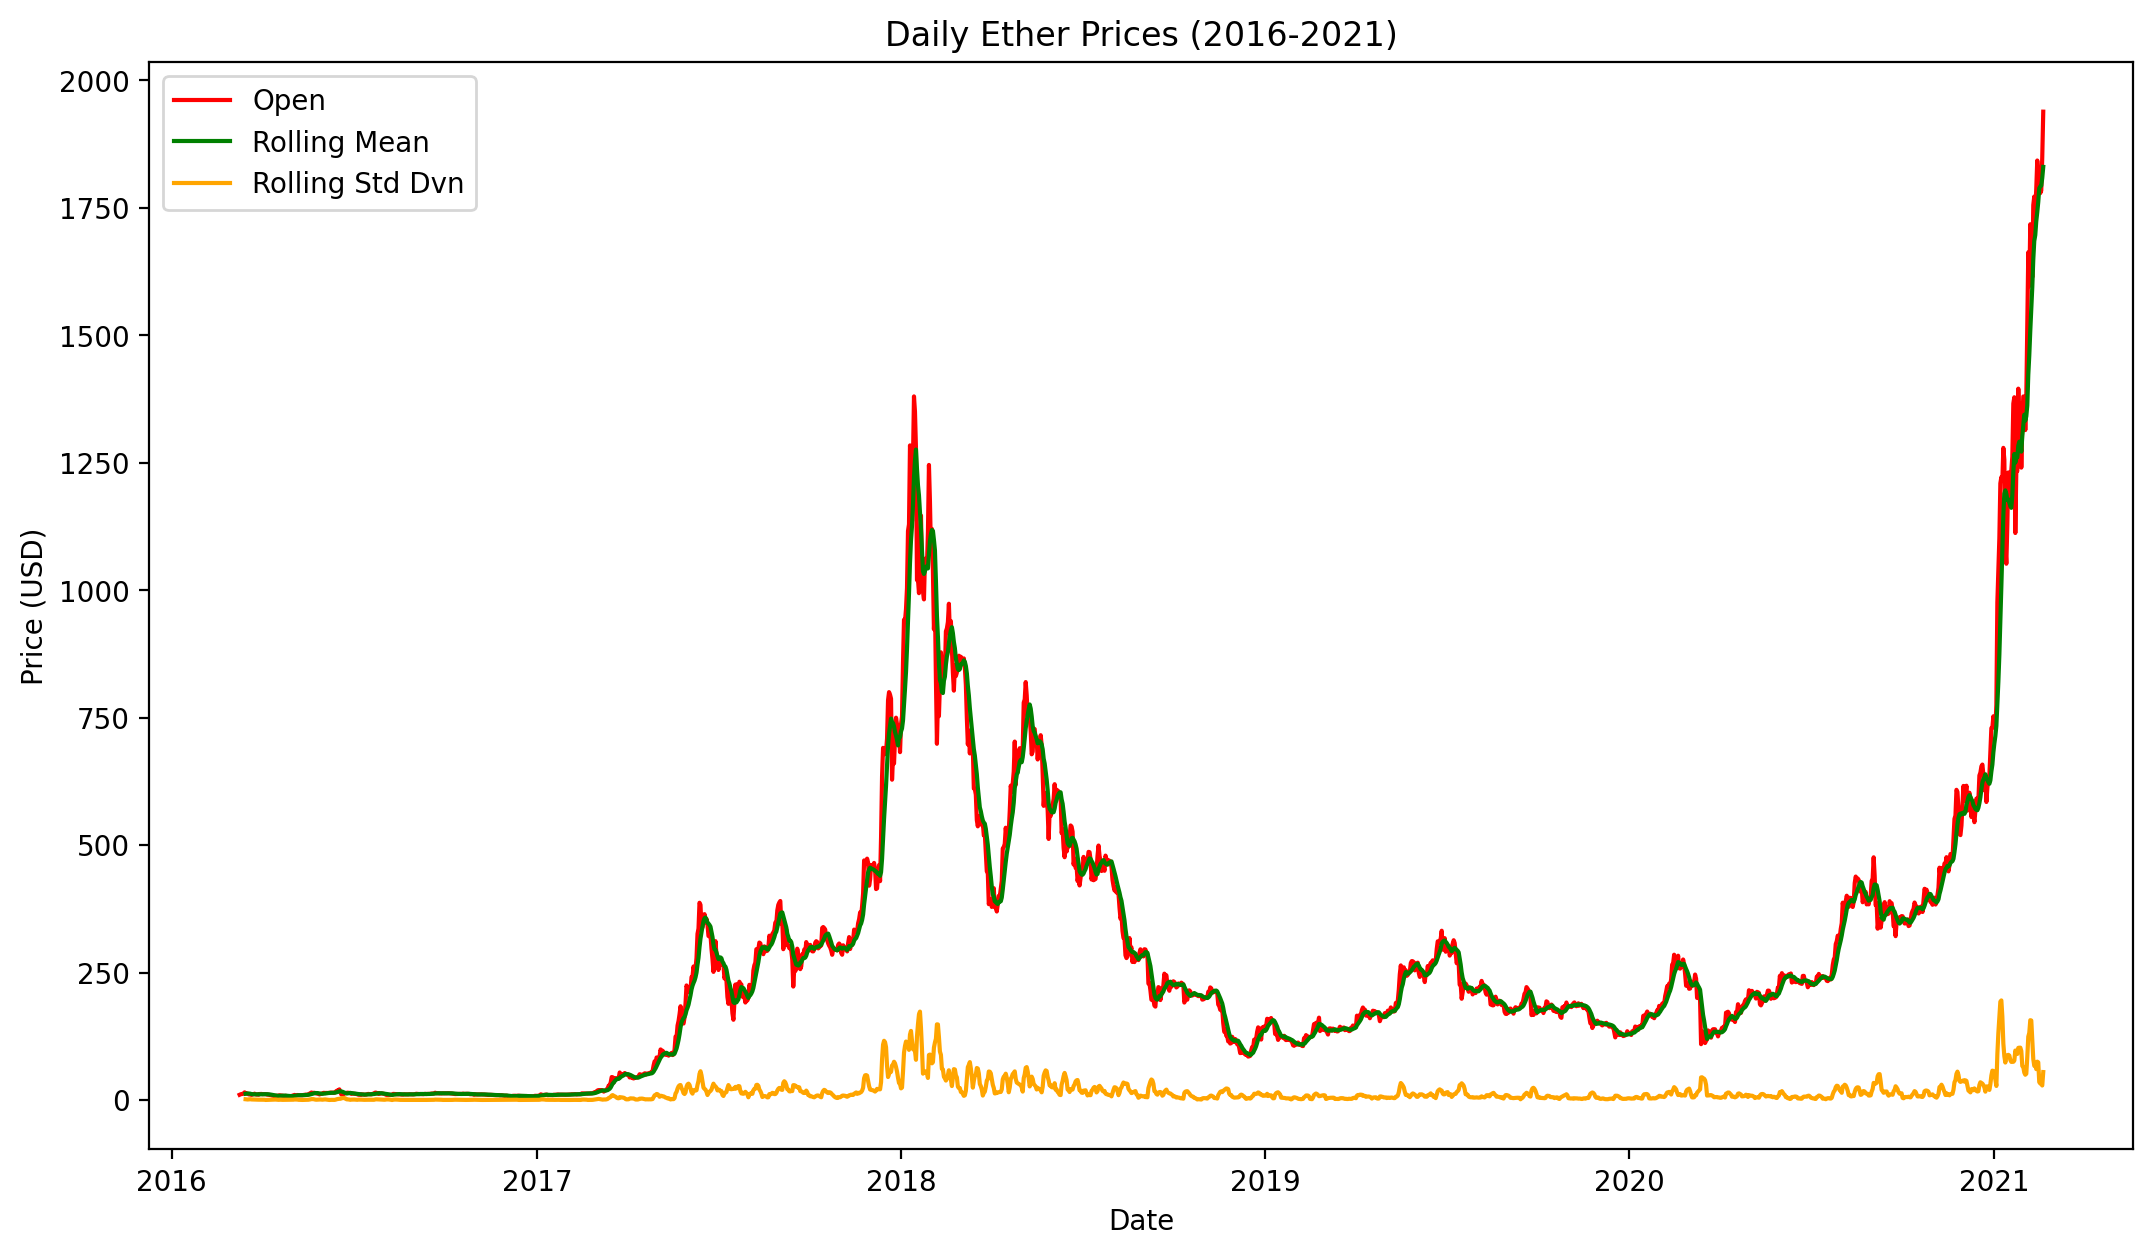

In [190]:
plot_time_series(((ether_data["Open"], "red", "Open"), (rolling_mean["Open"], "green", "Rolling Mean"), (rolling_standard_deviation["Open"], "orange", "Rolling Std Dvn")), "Date", "Price (USD)", "Daily Ether Prices (2016-2021)")

In [191]:
training_size = int(len(ether_data) * 0.8)
test_size = len(ether_data) - training_size
train_ether_data = ether_data[:training_size]
test_ether_data = ether_data[training_size:]
train_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)
test_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)

C:\Users\samee\AppData\Local\Temp\ipykernel_5524\1028042675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)
C:\Users\samee\AppData\Local\Temp\ipykernel_5524\1028042675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)


In [192]:
train_ether_data

,Open
Date,
2016-03-09,10.30
2016-03-10,11.20
2016-03-11,11.75
2016-03-12,11.95
2016-03-13,12.92
...,...
2020-02-19,283.00
2020-02-20,258.56
2020-02-21,257.67


In [193]:
test_ether_data

,Open
Date,
2020-02-24,275.590000
2020-02-25,266.110000
2020-02-26,247.360000
2020-02-27,224.110000
2020-02-28,227.410000
...,...
2021-02-15,1801.300000
2021-02-16,1778.500000
2021-02-17,1783.710981


In [194]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = min_max_scaler.fit_transform(train_ether_data)
scaled_test = min_max_scaler.fit_transform(test_ether_data)

In [195]:
scaled_train

array([[0.00263469],
       [0.00329008],
       [0.0036906 ],
       ...,
       [0.1827736 ],
       [0.18847554],
       [0.18602873]])

In [196]:
scaled_test

array([[0.09081912],
       [0.08563539],
       [0.07538276],
       [0.06266951],
       [0.06447397],
       [0.06469816],
       [0.05941601],
       [0.0596402 ],
       [0.06726815],
       [0.06283355],
       [0.06321085],
       [0.06556212],
       [0.07468832],
       [0.0703248 ],
       [0.04959536],
       [0.05152012],
       [0.05005468],
       [0.04708005],
       [0.        ],
       [0.01406387],
       [0.00758968],
       [0.0080654 ],
       [0.00123578],
       [0.00371829],
       [0.00501422],
       [0.01476378],
       [0.01312883],
       [0.01271325],
       [0.00699913],
       [0.01475284],
       [0.01604331],
       [0.01457787],
       [0.01599956],
       [0.01188211],
       [0.01188758],
       [0.00834427],
       [0.01243985],
       [0.01295932],
       [0.01473644],
       [0.01766185],
       [0.01754156],
       [0.01920385],
       [0.01830709],
       [0.0338364 ],
       [0.03029309],
       [0.03480971],
       [0.0330818 ],
       [0.026

In [197]:
lstm_train_x, lstm_train_y = prepare_for_lstm(scaled_train, 7)
lstm_test_x, lstm_test_y = prepare_for_lstm(scaled_test, 7)
lstm_train_x = np.reshape(lstm_train_x, (lstm_train_x.shape[0], lstm_train_x.shape[1], 1))
lstm_test_x = np.reshape(lstm_test_x, (lstm_test_x.shape[0], lstm_test_x.shape[1], 1))

In [198]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=64, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 7, 128)            66560     
                                                                 
 dropout_8 (Dropout)         (None, 7, 128)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [206]:
model.compile(optimizer="adam", loss="mean_squared_error")
training_result = model.fit(lstm_train_x, lstm_train_y, batch_size=32, epochs=50, verbose=1, shuffle=False, validation_data=(lstm_test_x, lstm_test_y), callbacks=None)

Epoch 1/50
45/45 [==============================] - 3s 22ms/step - loss: 0.0023 - val_loss: 0.0106
Epoch 2/50
45/45 [==============================] - 0s 10ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 3/50
45/45 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 4/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 5/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 6/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 7/50
45/45 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 8/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 9/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 10/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 11/50
45/

In [200]:
training_result.history

{'loss': [0.025317436084151268,
  0.02306998334825039,
  0.007025464903563261,
  0.006985606160014868,
  0.009819422848522663],
 'val_loss': [0.02718685008585453,
  0.004668975714594126,
  0.009364238008856773,
  0.017292747274041176,
  0.00165810517501086]}

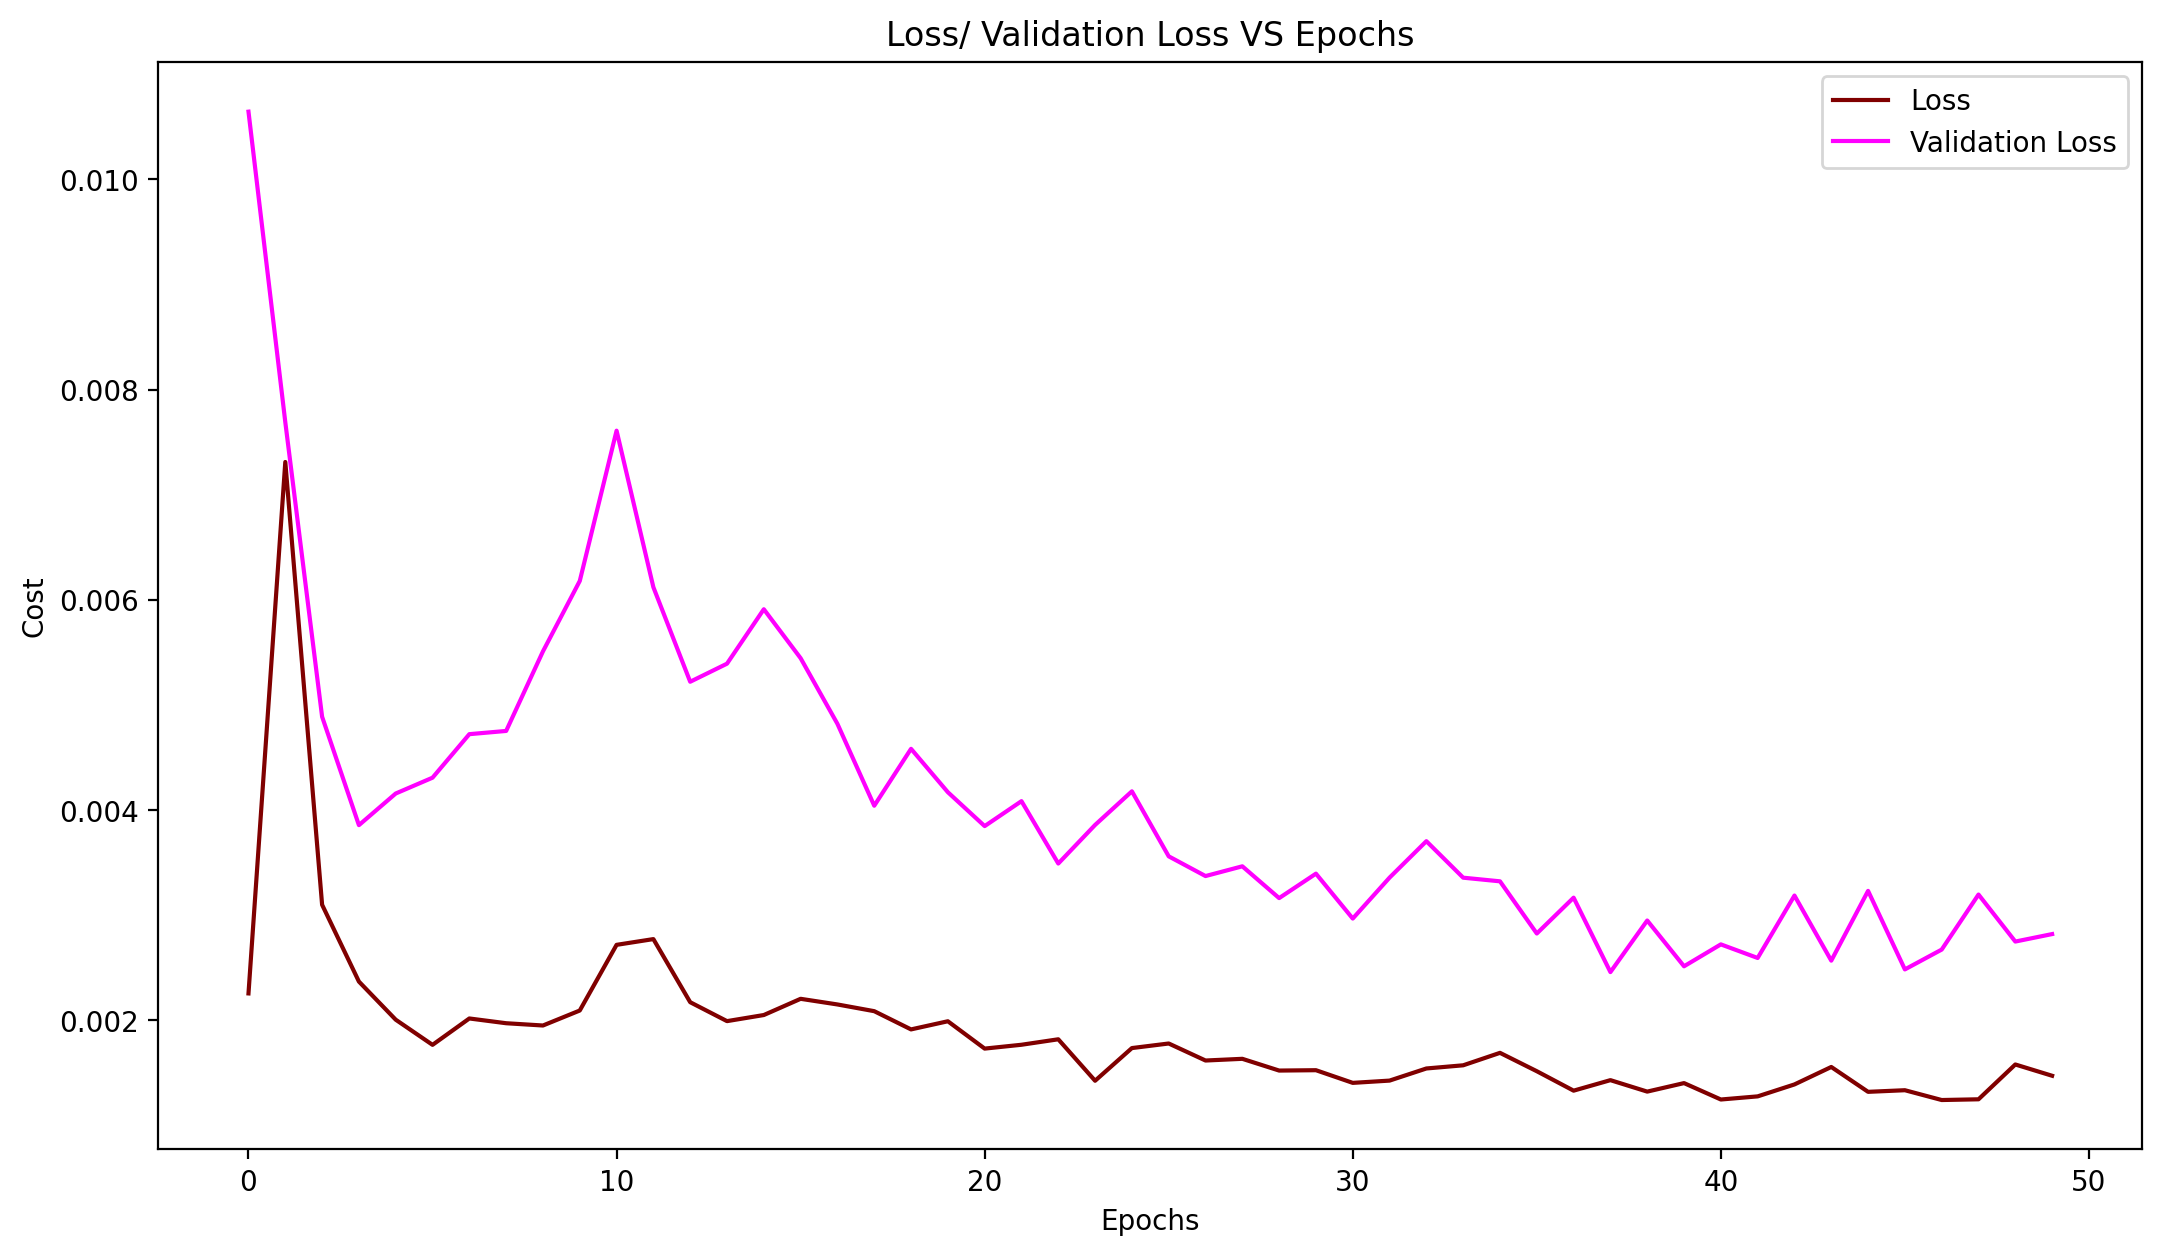

In [207]:
plot_time_series(((training_result.history["loss"], "maroon", "Loss"), (training_result.history["val_loss"], "magenta", "Validation Loss")), "Epochs", "Cost", "Loss/ Validation Loss VS Epochs")

In [208]:
actual_ether_data = min_max_scaler.inverse_transform(lstm_test_y.reshape(-1, 1))
predicted_ether_data = model.predict(lstm_test_x)
predicted_ether_data = min_max_scaler.inverse_transform(predicted_ether_data.reshape(-1, 1))

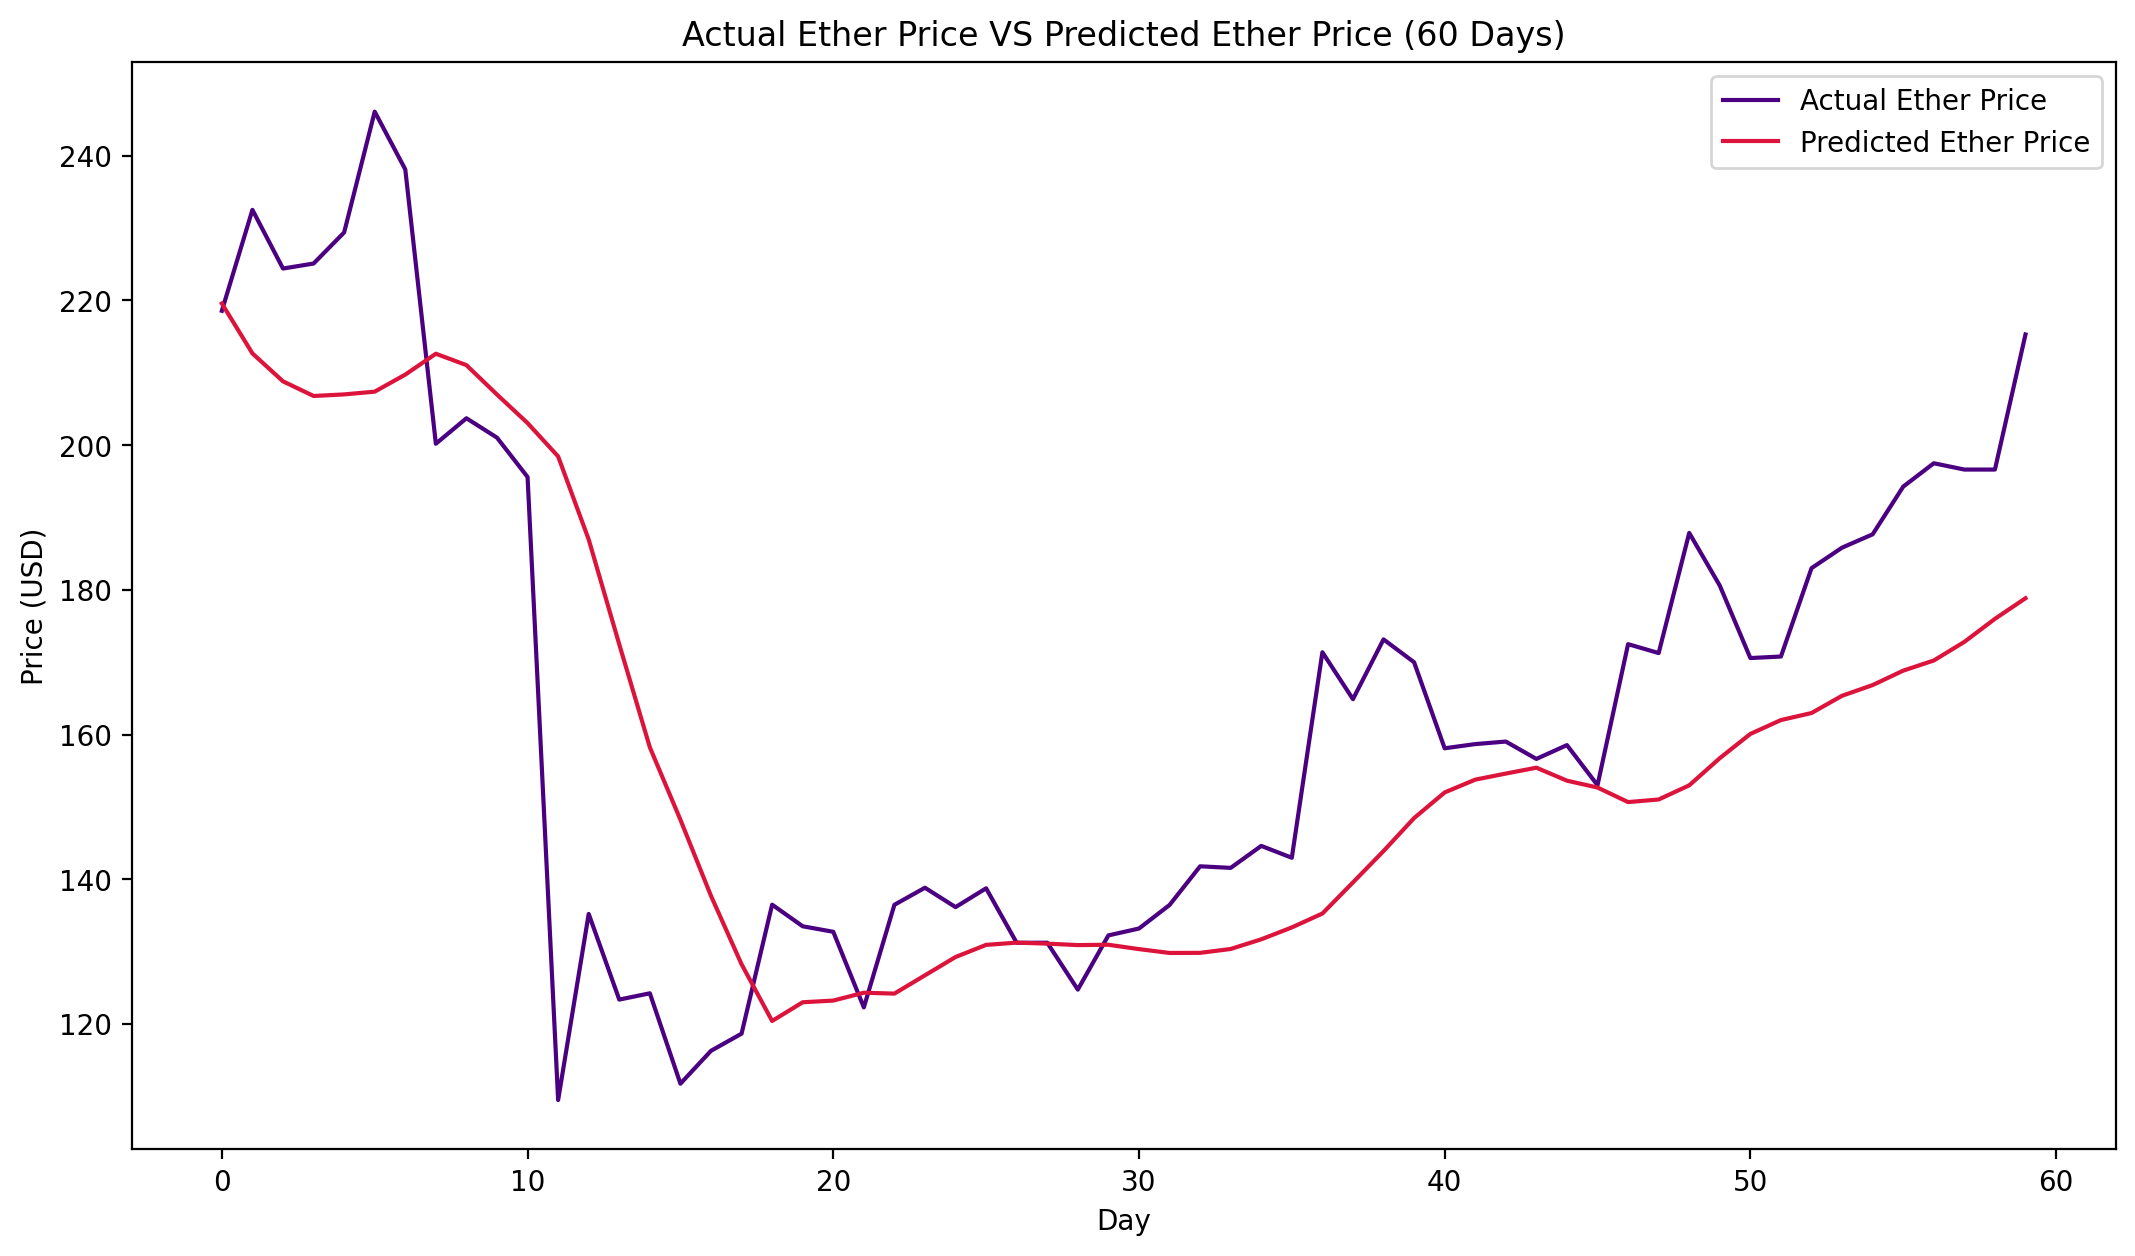

In [210]:
plot_time_series(((actual_ether_data[:60], "indigo", "Actual Ether Price"), (predicted_ether_data[:60], "crimson", "Predicted Ether Price")), "Day", "Price (USD)", "Actual Ether Price VS Predicted Ether Price (60 Days)")